# Preambule

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(qs)
library(parallel)
library(randomForest)
library(inTrees)
library(endoR)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


qs v0.23.4.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package

In [2]:
library(viridis)

Loading required package: viridisLite



In [3]:
library(ggpubr)

In [4]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        viridis_0.5.1       viridisLite_0.3.0  
 [4] endoR_0.1.0         inTrees_1.3         randomForest_4.6-14
 [7] qs_0.23.4           data.table_1.13.4   caret_6.0-86       
[10] lattice_0.20-41     forcats_0.5.0       stringr_1.4.0    

In [5]:
file.sources <- list.files('../scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Results

In [6]:
fnames <- list.files('/ebio/abt3_projects/temp_data/aruaud/MtgSimu50/', full.names = TRUE
                     ,recursive = TRUE, pattern = 'simu')
fnames <- fnames[-str_which(fnames, pattern = 'bis')]

In [7]:
fnames <- str_subset(fnames, pattern = 'B10/')

In [8]:
seedN <- as.numeric(str_extract(fnames, pattern = '(?<=simu)[:digit:]*(?=\\_)'))
fnames <- fnames[which(seedN %in% 1:50)]

In [9]:
length(fnames)

[1] 150

# check

In [10]:
getRes <- function(f, p = NULL, related_taxa, alpha_error = 10){
    pre_res <- qread(f)
    p <- as.numeric(str_extract(f, pattern = '(?<=p)[:digit:]+(?=\\_B)'))/10
    if (p == 0.5){p <- 0.05}
    
    # get the true edges
    te <- lapply(pre_res$true_edges, str_replace_all, pattern = '\\_{2}.*', replacement = '')
    te <- unique(lapply(te, sort))
    expanded_edges <- list()
    for (i in 1:length(te)){
        tmp <- te[[i]] %>% str_replace(pattern = '\\_{2}.*', replacement = '')
        tmp <- related_taxa[tmp]
        tmp <- expand.grid(tmp[[1]], tmp[[2]])  
        tmp <- asplit(tmp, MARGIN=1)

        expanded_edges[[i]] <- sapply(lapply(tmp, sort), paste, collapse = ' - ')
        names(expanded_edges)[i] <- paste(sort(te[[i]]), collapse = ' - ')
    }
        
    # get the new metrics
    quiet(pc <- stabilitySelection(pre_res$resampled, alpha_error = alpha_error, pi_thr = 0.7))
    cond <- pc$rules_summary %>% subset(inN >= 7, select = condition) %>% unlist
    if (length(cond) > 0){
            
        imp_edges <- pc$edges_agg %>% subset(condition %in% cond) %>% select(x,y, importance, n, imp)
        imp_edges$x <- str_replace(imp_edges$x, pattern = '\\_{2}.*', replacement = '')
        imp_edges$y <- str_replace(imp_edges$y, pattern = '\\_{2}.*', replacement = '')
        suppressMessages(imp_edges <- imp_edges %>% group_by(x,y) %>% summarise(importance = sum(n*imp*importance)))
        imp_edges <- asplit(as.matrix(imp_edges), MARGIN = 1)
        imp_edges <- lapply(imp_edges, sort) 
        pred_edges <- sapply(imp_edges, function(x){paste(x[-1], collapse = ' - ')}) 
        imp_edges <- sapply(imp_edges, function(x)x['importance']) 

        # those that should not be but are = in pred_edges but not truth
        fp <- sum(sapply(pred_edges, function(x){!(x %in% unlist(expanded_edges))}))
        tp <- sum(sapply(expanded_edges, function(x){ifelse(sum(x %in% pred_edges) > 0, 1, 0)}))
        fn <- sum(sapply(names(expanded_edges), function(x){!(x %in% pred_edges)}))


        # sum of FP importances
        if(fp > 0) {
            fp_imp <- which(sapply(pred_edges, function(x){!(x %in% unlist(expanded_edges))}))
            fp_imp <- sum(as.numeric(imp_edges[fp_imp]))
        } else {fp_imp <- 0}
        # sum of TP importances
        if(tp > 0) {
            tp_imp <- list()
            for (i in 1:length(expanded_edges)){
                tp_imp[[i]] <- mean(as.numeric(imp_edges[which(pred_edges %in% expanded_edges[[i]])]))
            }
            tp_imp <- sum(unlist(tp_imp), na.rm = TRUE)
        } else {tp_imp <- 0}

        res <- c('p' = p, 'rf_accuracy' = pre_res$gamma_all[1, 'meanK'], 'n_decisions' = length(cond)
                , 'tp_imp' = tp_imp, 'fp_imp' = fp_imp, 'tp' = tp, 'fp' = fp
                , 'fn' = fn)
    } else {
        res <- c('p' = p, 'rf_accuracy' = pre_res$gamma_all[1, 'meanK'], 'n_decisions' = NA
                , 'tp_imp' = NA, 'fp_imp' = NA, 'tp' = NA, 'fp' = NA, 'fn' = NA)
    }
    
    return(res)
}

In [11]:
related_taxa <- qread('../tmp/related_taxa_full.qs')
is_s <- str_which(names(related_taxa), pattern = '^s_')
related_taxa[is_s] <- related_taxa[is_s] %>% lapply(function(x){str_subset(x, pattern = '^s|g')})
related_taxa$groupa <- 'groupa'
related_taxa$groupb <- 'groupb'
related_taxa$groupc <- 'groupc'
related_taxa$groupd <- 'groupd'

In [12]:
check <- sapply(fnames, getRes, related_taxa = related_taxa, alpha_error = 5)
check <- as.data.frame(t(check))

In [13]:
check$precision <- check$tp/(check$tp+check$fp)
check$recall <- check$tp/(check$tp+check$fn)
check$w_precision <- check$tp_imp/(check$tp_imp+check$fp_imp)

In [14]:
check[complete.cases(check),] %>% dim

[1] 150  11

In [15]:
check %>% subset(tp == 0) %>% count(p)

p,n
<dbl>,<int>


In [16]:
check[ complete.cases(check), ] %>% group_by(p) %>% summarise_all(mean) %>% #subset(N != 1000) %>% 
select(rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9580307,24.70,8.20,15.40,1.10,898.62283,19.40421,0.3836248,0.8867648,0.9757764
0.9058784,26.10,7.76,17.42,1.82,225.55613,20.34507,0.3400354,0.8169406,0.8989458
0.8452213,31.32,7.24,20.40,2.40,79.42469,20.59334,0.2829908,0.7528333,0.7664447


In [17]:
check[ complete.cases(check), ] %>% group_by(p) %>% summarise_all(sd) %>% #subset(N != 1000) %>% 
select(rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01965757,10.664168,1.551826,7.892130,1.681229,328.07144,14.52853,0.1256266,0.1785004,0.02049733
0.02310016,9.463679,1.756155,8.689872,1.976288,137.39915,17.18017,0.1113845,0.2017214,0.07610635
0.03182804,12.243182,1.974945,9.598044,1.969150,54.14119,17.64019,0.1129482,0.2129018,0.15387751


In [18]:
check[ complete.cases(check), ] %>% count(p)

p,n
<dbl>,<int>
0.00,50
0.05,50
0.10,50


# plots

In [19]:
tmp_av <- check %>% group_by(p) %>% summarise_all(mean, na.rm = TRUE)
tmp_av

p,rf_accuracy,n_decisions,tp_imp,fp_imp,tp,fp,fn,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.9580307,24.70,898.62283,19.40421,8.20,15.40,1.10,0.3836248,0.8867648,0.9757764
0.05,0.9058784,26.10,225.55613,20.34507,7.76,17.42,1.82,0.3400354,0.8169406,0.8989458
0.10,0.8452213,31.32,79.42469,20.59334,7.24,20.40,2.40,0.2829908,0.7528333,0.7664447


In [20]:
cols <- plasma(length(unique(check$p)) + 3)
cols <- cols[-c(1,length(cols))]

In [21]:
recall <- ggplot(check, aes(x =rf_accuracy, y = recall, color = as.character(p))) + 
geom_hline(yintercept = 0.5, color = 'lightgrey')+
geom_point(size = 3, alpha = 0.5)+
geom_point(data = tmp_av, size = 5, alpha = 1, shape = 21, color = 'white', fill = 'black')+
geom_point(data = tmp_av, size = 4, alpha = 1, shape = 21, color = 'black', aes(fill = as.character(p)))+

theme_classic() + 
labs(x = expression("RF Cohen's "*kappa), y = 'Recall'
     , title = expression('r varies, n = 1000, B = 10, '*alpha*' = 5'))+
scale_color_manual(values = cols, name = 'r', guide = guide_legend(override.aes = list(alpha = .8) ))+
theme(legend.position = 'bottom', legend.text = element_text(size = rel(1.2))
              , legend.title = element_text(size = rel(1.2)) )+
scale_fill_manual(values = cols, name = 'r', guide = 'none')+
ylim(c(0,1))

In [22]:
wprec <- ggplot(check, aes(x =rf_accuracy, y = w_precision, color = as.character(p))) + 
geom_hline(yintercept = 0.5, color = 'lightgrey')+
geom_point(size = 3, alpha = 0.5)+
geom_point(data = tmp_av, size = 5, alpha = 1, shape = 21, color = 'white', fill = 'black')+
geom_point(data = tmp_av, size = 4, alpha = 1, shape = 21, color = 'black', aes(fill = as.character(p)))+

theme_classic() + 
labs(x = expression("RF Cohen's "*kappa), y = 'Weighted precision'
     , title = expression('r varies, n = 1000, B = 10, '*alpha*' = 5')
    )+
scale_color_manual(values = cols, name = 'r', guide = guide_legend(override.aes = list(alpha = .8) ))+
scale_fill_manual(values = cols, name = 'r', guide = 'none')

In [23]:
ndec <- ggplot(check, aes(x =rf_accuracy, y = n_decisions, color = as.character(p))) + 
geom_hline(yintercept = 0, color = 'lightgrey')+
geom_point(size = 3, alpha = 0.75)+
geom_point(data = tmp_av, size = 5, alpha = 1, shape = 21, color = 'white', fill = 'black')+
geom_point(data = tmp_av, size = 4, alpha = 1, shape = 21, color = 'black', aes(fill = as.character(p)))+

theme_classic() + 
labs(x = expression("RF Cohen's "*kappa), y = '# decisions', title = expression('r varies, n = 1000, B = 10, '*alpha*' = 5'))+
scale_color_manual(values = cols, name = 'r', guide = guide_legend(override.aes = list(alpha = .8) ))+
scale_fill_manual(values = cols, name = 'r', guide = 'none')

In [24]:
pall <- ggarrange(recall, wprec, ndec, ncol = 3, nrow = 1, common.legend = TRUE, legend = 'right')

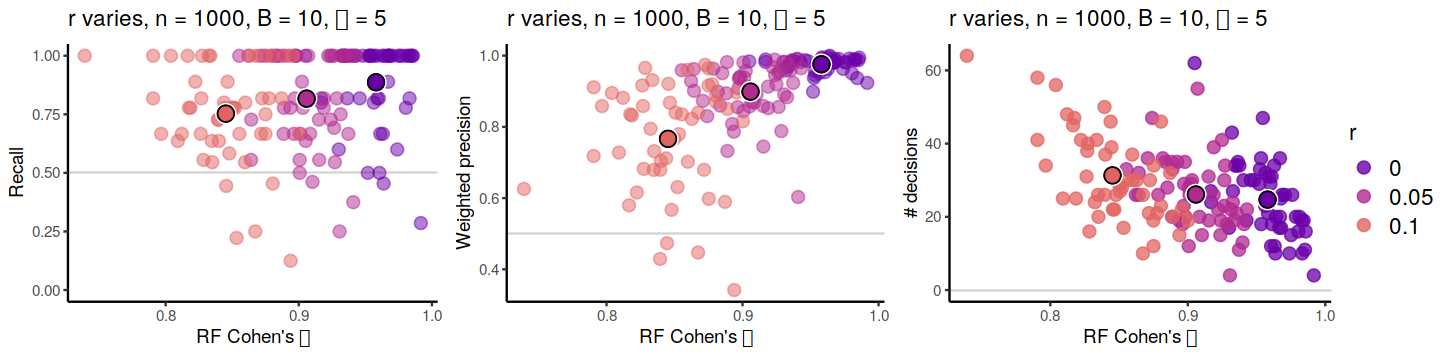

In [25]:
options(repr.plot.width=12, repr.plot.height=3)
pall

# stat

In [26]:
cat('Recall:')
tmp <- cor.test(x = check$rf_accuracy, y = check$recall, method = 'pearson')
tmp 
cat('r2 = ', tmp$estimate^2)

Recall:


	Pearson's product-moment correlation

data:  check$rf_accuracy and check$recall
t = 1.9362, df = 148, p-value = 0.05475
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.003168372  0.309635156
sample estimates:
     cor 
0.157173 


r2 =  0.02470334

In [27]:
cat('Weighted precision:')
tmp <- cor.test(x = check$rf_accuracy, y = check$w_precision, method = 'pearson')
tmp 
cat('r2 = ', tmp$estimate^2)

Weighted precision:


	Pearson's product-moment correlation

data:  check$rf_accuracy and check$w_precision
t = 8.5387, df = 148, p-value = 1.509e-14
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4562371 0.6728098
sample estimates:
      cor 
0.5744933 


r2 =  0.3300425

In [28]:
cat('N decisions:')
tmp <- cor.test(x = check$rf_accuracy, y = check$n_decisions, method = 'pearson')
tmp 
cat('r2 = ', tmp$estimate^2)

N decisions:


	Pearson's product-moment correlation

data:  check$rf_accuracy and check$n_decisions
t = -6.7043, df = 148, p-value = 3.982e-10
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5967555 -0.3494199
sample estimates:
       cor 
-0.4826535 


r2 =  0.2329544